# Exploitation of the data generated by the verifiers

In [20]:
from datasets import load_from_disk,Dataset
import pandas as pd
import seaborn as sb

ds_path =f"notebooks/verifier_execution/2025-11-03-14-ds_conc" 
full_ds = load_from_disk(ds_path)

### TP FP rates

In [21]:
def compute_tpfp(row):
    cl = "unassigned"
    expected = bool(row["expected"])
    classified = bool(row["classified"])
    if expected and classified:
        cl = "TP"
    if not expected and classified:
        cl = "FP"
    if expected and not classified:
        cl = "FN"
    if not expected and not classified:
        cl = "TN" 
    row["classification"] = cl
    
    return row

In [22]:

rates_ds = full_ds.map(compute_tpfp)
rates_df = rates_ds.to_pandas()
rates_df = rates_df[["approach_name","classification","id","try","index","classified","expected"]]

Map: 100%|██████████| 75/75 [00:00<00:00, 462.48 examples/s]


In [23]:
rates_df

,approach_name,classification,id,try,index,classified,expected
0,TextVerifier,TP,beam_coord_change,0,0,True,True
1,TextVerifier,FP,beam_coord_change,0,1,True,False
2,TextVerifier,FN,bee_eyes,0,2,False,True
3,TextVerifier,FP,bee_eyes,0,3,True,False
4,TextVerifier,FN,bee_longer_body,0,4,False,True
...,...,...,...,...,...,...,...
70,TextVisualVerifier,TP,cat_big,0,20,True,True
71,TextVisualVerifier,FP,cat_big,0,21,True,False
72,TextVisualVerifier,TP,cat_blue_nose,0,22,True,True
73,TextVisualVerifier,TP,cat_blue_nose,0,23,True,True


In [24]:
rates_agg_df = (
    rates_df.groupby(["index","approach_name"], as_index=False)
    .agg(lambda x: (
        "TP" if "TP" in x.values
        else "TN" if "TN" in x.values
        else x.iloc[0] if "FP" in x.values or "FN" in x.values
        else "classification_error"
    ) if x.name == "classification" else x.iloc[0])
)


Text(0.5, 0, '')

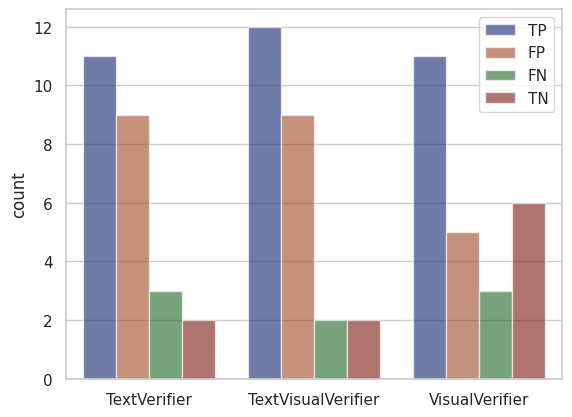

In [25]:
import seaborn as sns
import matplotlib.ticker as ticker

sns.set_theme(style="whitegrid")

g = sns.countplot(
    data=rates_agg_df,
    x="approach_name",
    hue="classification",
    palette="dark",
    alpha=0.6,
)

g.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
g.legend_.set_title(None)
g.set_xlabel("")


### Precision and recall

In [28]:
import pandas as pd

def compute_metrics(group):
    TP = (group["classification"] == "TP").sum()
    FP = (group["classification"] == "FP").sum()
    FN = (group["classification"] == "FN").sum()
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return pd.Series({"precision": precision, "recall": recall, "f1": f1})

metrics_df = rates_agg_df.groupby("approach_name").apply(compute_metrics).reset_index()
metrics_df


/tmp/ipykernel_236304/830651736.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = rates_agg_df.groupby("approach_name").apply(compute_metrics).reset_index()


,approach_name,precision,recall,f1
0,TextVerifier,0.550000,0.785714,0.647059
1,TextVisualVerifier,0.571429,0.857143,0.685714
2,VisualVerifier,0.687500,0.785714,0.733333


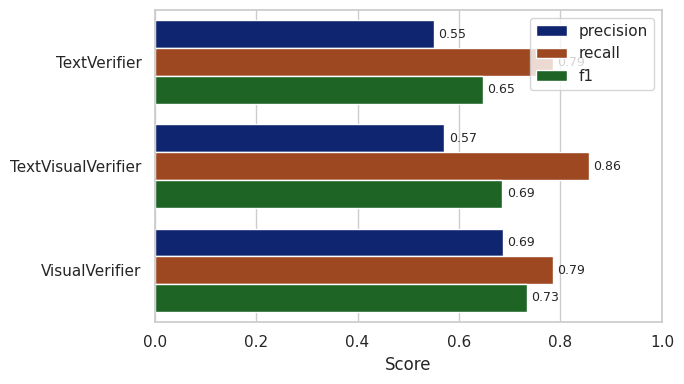

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics_melted = metrics_df.melt(id_vars="approach_name", var_name="metric", value_name="score")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 4))

g = sns.barplot(
    data=metrics_melted,
    y="approach_name",
    x="score",
    hue="metric",
    palette="dark",
    orient="h"
)

# Add value labels
for container in g.containers:
    g.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=9)

g.set_ylabel("")
g.set_xlabel("Score")
g.legend_.set_title("")
g.set_xlim(0, 1)

plt.tight_layout()
plt.show()


### Error classifications

In [14]:
err_df = full_ds.to_pandas()
